<a href="https://colab.research.google.com/github/ELBrown11/Analyzing-Customer-Churn-using-Machine-Learning/blob/main/CustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# **Import Data**
- create `original_data` to store raw data as variable
- create `data` as copy of to be altered during data cleaning

In [2]:
original_data = pd.read_csv('/content/drive/MyDrive/Data Scientist Blog Post/Databel - Data.csv')
data = original_data.copy()

# **Preview Data**

In [5]:
data.head()

,Customer ID,Churn Label,Account Length (in months),Local Calls,Local Mins,Intl Calls,Intl Mins,Intl Active,Intl Plan,Extra International Charges,...,Senior,Group,Number of Customers in Group,Device Protection & Online Backup,Contract Type,Payment Method,Monthly Charge,Total Charges,Churn Category,Churn Reason
0,4444-BZPU,No,1,3,8.0,0.0,0.0,No,no,0.0,...,No,No,0,No,Month-to-Month,Direct Debit,10,10,NaN,NaN
1,5676-PTZX,No,33,179,431.3,0.0,0.0,No,no,0.0,...,No,No,0,Yes,One Year,Paper Check,21,703,NaN,NaN
2,8532-ZEKQ,No,44,82,217.6,0.0,0.0,No,yes,0.0,...,No,No,0,Yes,One Year,Direct Debit,23,1014,NaN,NaN
3,1314-SMPJ,No,10,47,111.6,60.0,71.0,Yes,yes,0.0,...,No,No,0,No,Month-to-Month,Paper Check,17,177,NaN,NaN
4,2956-TXCJ,No,62,184,621.2,310.0,694.4,Yes,yes,0.0,...,No,No,0,No,One Year,Direct Debit,28,1720,NaN,NaN


# **Data Exploration**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6687 entries, 0 to 6686
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        6687 non-null   object 
 1   Churn Label                        6687 non-null   object 
 2   Account Length (in months)         6687 non-null   int64  
 3   Local Calls                        6687 non-null   int64  
 4   Local Mins                         6687 non-null   float64
 5   Intl Calls                         6687 non-null   float64
 6   Intl Mins                          6687 non-null   float64
 7   Intl Active                        6687 non-null   object 
 8   Intl Plan                          6687 non-null   object 
 9   Extra International Charges        6687 non-null   float64
 10  Customer Service Calls             6687 non-null   int64  
 11  Avg Monthly GB Download            6687 non-null   int64

- `Churn Category` and `Churn Reason` are the only columns with missing data.
- this makes sense because some customers are retained and therefore no data would populate for this column

# **Data Cleaning**

In [3]:
# Convert column names to lowercased and underscored
data.columns = data.columns.str.lower().str.replace(' ', '_')

# Display modified column names
print("\nModified column names:")
print(data.columns)


Modified column names:
Index(['customer_id', 'churn_label', 'account_length_(in_months)',
       'local_calls', 'local_mins', 'intl_calls', 'intl_mins', 'intl_active',
       'intl_plan', 'extra_international_charges', 'customer_service_calls',
       'avg_monthly_gb_download', 'unlimited_data_plan', 'extra_data_charges',
       'state', 'phone_number', 'gender', 'age', 'under_30', 'senior', 'group',
       'number_of_customers_in_group', 'device_protection_&_online_backup',
       'contract_type', 'payment_method', 'monthly_charge', 'total_charges',
       'churn_category', 'churn_reason'],
      dtype='object')


- converting the column names to the snake case for ease of use
- snake case is the convention where everything is lowercased and spaces are replaced with underscored

In [8]:
data['churn_label'].value_counts(normalize=True)

,proportion
churn_label,
No,0.731419
Yes,0.268581


- most customers do not churn but almost 27% of customers churn is a significant churn rate

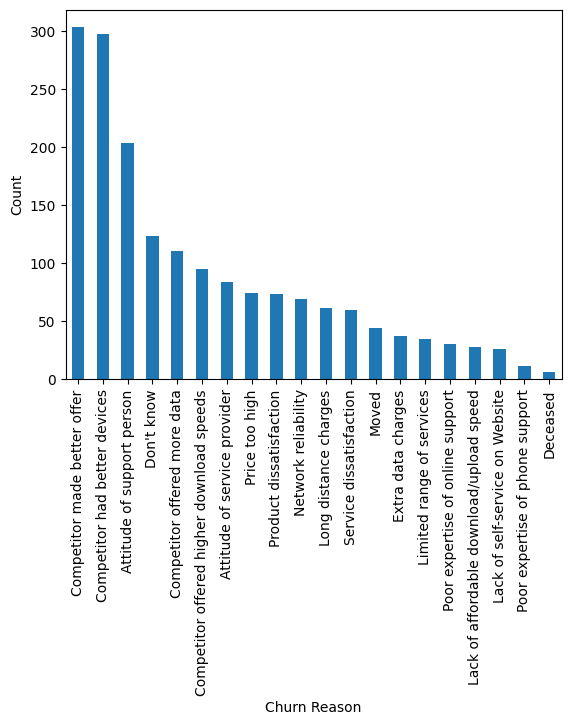

In [9]:
data['churn_reason'].value_counts().plot(kind='bar');
plt.xlabel('Churn Reason')
plt.ylabel('Count')
plt.show()

- 3 of top 5  reasons that customers churn are related to the "competitor"  

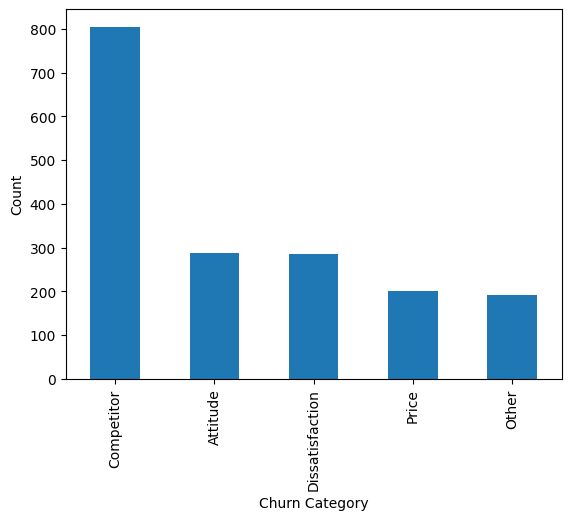

In [10]:
data['churn_category'].value_counts().plot(kind='bar');
plt.xlabel('Churn Category')
plt.ylabel('Count')
plt.show()

- this finding is inline with what we just saw via churn reason, competitors seem to be doing something to intice customers to leave


# **Answering Business Questions**

What features make a customer more likely to churn?
What percentage of customers are churning?
Is there a relationships between certain demographics (eg. age groups, genders, location) and churn rate?
Which churn categories are most likely to churn?

churn_label                     1.000000
customer_service_calls          0.635533
monthly_charge                  0.214691
age                             0.107517
avg_monthly_gb_download         0.039947
extra_data_charges              0.005222
extra_international_charges    -0.019699
intl_mins                      -0.085395
intl_calls                     -0.092295
total_charges                  -0.173316
number_of_customers_in_group   -0.226341
local_calls                    -0.282273
local_mins                     -0.294757
account_length_(in_months)     -0.351517
Name: churn_label, dtype: float64


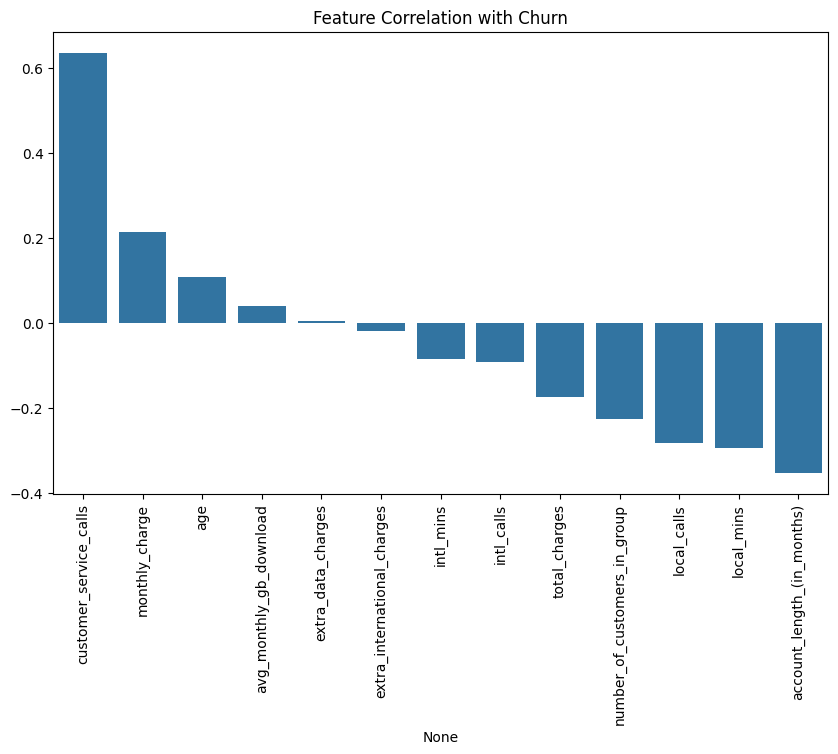

In [6]:
#What features make a customer more likely to churn?
# Convert churn label to binary (Yes = 1, No = 0)
data['churn_label'] = data['churn_label'].map({'Yes': 1, 'No': 0})

# Compute correlation with churn
correlation = data.corr(numeric_only=True)['churn_label'].sort_values(ascending=False)
print(correlation)

# Visualizing feature importance with barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.index[1:], y=correlation.values[1:])
plt.xticks(rotation=90)
plt.title("Feature Correlation with Churn")
plt.show()

In [5]:
data['churn_label'].value_counts()

,count
churn_label,
No,4891
Yes,1796
